In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
nifty = pdr.get_data_yahoo('^NSEI', 
                          start=datetime.datetime(2010, 10, 1), 
                          end=datetime.datetime(2020, 1, 1))

In [3]:
nifty_50 = pd.DataFrame(index = nifty.index)
nifty_50['Open'] = nifty['Open']
nifty_50['High'] = nifty['High']
nifty_50['Low'] = nifty['Low']
nifty_50['Close'] = nifty['Close']
nifty_50['Adj Close'] = nifty['Adj Close']
nifty_50['Volume'] = nifty['Volume']
nifty_50.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-01,6030.299805,6153.100098,6030.299805,6143.399902,6143.399902,0.0
2010-10-04,6144.700195,6222.100098,6144.700195,6159.450195,6159.450195,0.0
2010-10-05,6159.450195,6188.350098,6118.049805,6145.799805,6145.799805,0.0
2010-10-06,6150.950195,6223.399902,6148.600098,6186.450195,6186.450195,0.0
2010-10-07,6186.850098,6199.450195,6107.500000,6120.299805,6120.299805,0.0


In [4]:
nifty_50.to_csv(r'C:\Users\hp\anaconda3\Lib\site-packages\np.txt',mode='a')

In [5]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

In [22]:
class TestStrategy(bt.Strategy):
    
    params = (('sma', 270),)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
      
        self.sma = btind.SimpleMovingAverage(self.data, period=self.p.sma)
        self.ind = btind.CrossOver(self.data.close,self.sma)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])
        
         # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            if self.ind > 0:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
            elif self.ind < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
            
        else:
            if self.getposition(data=self.data).size > 0 and self.ind < 0:
                self.log('Long ended, %.2f' % self.data.close[0])
                #Keep track of the created order to avoid a 2nd order
                self.order = self.close()
            elif self.getposition(data=self.data).size<0 and self.ind > 0:
                self.log('Short ended, %.2f' % self.data.close[0])  
                #Keep track of the created order to avoid a 2nd order
                self.order = self.close()


Starting Portfolio Value: 100000.00
2012-02-03, BUY CREATE, 5325.85
2012-02-06, BUY EXECUTED, Price: 5379.45, Cost: 26897.25, Comm 268.97
2012-02-27, Long ended, 5281.20
2012-02-28, SELL EXECUTED, Price: 5310.50, Cost: 26897.25, Comm 265.53
2012-02-28, OPERATION PROFIT, GROSS -344.75, NET -879.25
2012-02-28, BUY CREATE, 5375.50
2012-02-29, BUY EXECUTED, Price: 5424.95, Cost: 27124.75, Comm 271.25
2012-03-05, Long ended, 5280.35
2012-03-06, SELL EXECUTED, Price: 5266.00, Cost: 27124.75, Comm 263.30
2012-03-06, OPERATION PROFIT, GROSS -794.75, NET -1329.30
2012-03-09, BUY CREATE, 5333.55
2012-03-12, BUY EXECUTED, Price: 5420.10, Cost: 27100.50, Comm 271.01
2012-03-19, Long ended, 5257.05
2012-03-20, SELL EXECUTED, Price: 5257.15, Cost: 27100.50, Comm 262.86
2012-03-20, OPERATION PROFIT, GROSS -814.75, NET -1348.61
2012-03-21, BUY CREATE, 5364.95
2012-03-22, BUY EXECUTED, Price: 5361.10, Cost: 26805.50, Comm 268.06
2012-03-22, Long ended, 5228.45
2012-03-23, SELL EXECUTED, Price: 5255.65,

<IPython.core.display.Javascript object>


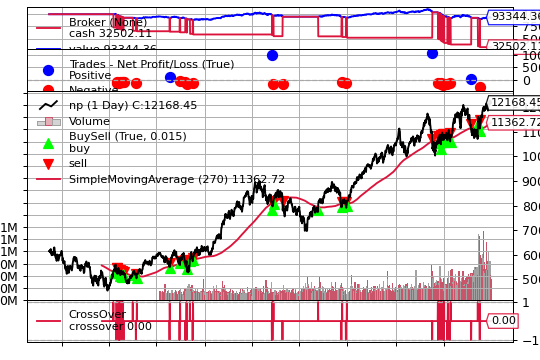

In [23]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    cerebro.addsizer(bt.sizers.SizerFix, stake=5)
    
    cerebro.addstrategy(TestStrategy)
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'np.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2010, 10, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 1),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.01)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()